## Imports and Generic Functions

In [1]:
import pandas as pd
import cv2
import sys
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from typing import Tuple


def rle_decode(rle_with_shape):
    """
    Decodes a Run-Length Encoding (RLE) string with shape into a binary mask.

    Parameters:
        rle_with_shape (str): RLE-encoded string with shape in the format "H,W:RLE".

    Returns:
        np.ndarray: Decoded binary mask where 255 represents the mask and 0 represents the background.
    """
    # Split the shape and RLE string
    shape_part, rle = rle_with_shape.split(":")
    height, width = map(int, shape_part.split(","))  # Extract height and width

    # Split the RLE string into a list of integers
    runs = list(map(int, rle.split()))

    # Create an empty array for the mask
    mask = np.zeros(height * width, dtype=np.uint8)

    # Iterate over the runs and set the mask values
    for start, length in zip(runs[::2], runs[1::2]):
        mask[start : start + length] = 255  # Set mask values to 255

    # Reshape the mask to the original shape
    return mask.reshape((height, width))


def rle_decode(rle_with_shape):
    """
    Decodes a Run-Length Encoding (RLE) string with shape into a binary mask.

    Parameters:
        rle_with_shape (str): RLE-encoded string with shape in the format "H,W:RLE".

    Returns:
        np.ndarray: Decoded binary mask where 255 represents the mask and 0 represents the background.
    """
    with open(rle_with_shape, "r") as f:
        rle_with_shape = f.read()
    # Split the shape and RLE string
    shape_part, rle = rle_with_shape.split(":")
    height, width = map(int, shape_part.split(","))  # Extract height and width

    # Split the RLE string into a list of integers
    runs = list(map(int, rle.split()))

    # Create an empty array for the mask
    mask = np.zeros(height * width, dtype=np.uint8)

    # Iterate over the runs and set the mask values
    for start, length in zip(runs[::2], runs[1::2]):
        mask[start : start + length] = 255  # Set mask values to 255

    # Reshape the mask to the original shape
    return mask.reshape((height, width))


def true_mask(image, bbox):
    x, y, w, h = map(int, bbox[1:-1].split(","))
    mask = np.zeros(image.shape[:2], dtype=np.uint8)

    # Mark the area of the bounding box in the mask
    mask[y : y + h, x : x + w] = 255
    return mask


def overlay_mask(image: np.ndarray, mask: np.ndarray, color=[0, 255, 0]):
    # Resize the mask to match the image size
    mask = cv2.resize(mask, (image.shape[1], image.shape[0]))

    # Ensure the mask is binary (0 or 1)
    mask = (mask > 0).astype(np.uint8)

    # Convert the mask to a 3-channel mask
    mask_3d = np.stack([mask] * 3, axis=-1)

    # Create a colored version of the mask
    colored_mask = mask_3d * np.array(color, dtype=np.uint8)

    # Copy the original image to overlay the mask
    overlayed = image.copy()

    # Apply cv2.addWeighted only to the masked region
    overlayed_mask_region = cv2.addWeighted(image, 0.5, colored_mask, 0.5, 0)

    # Assign the blended region back to the masked area of the image
    overlayed[mask_3d == 1] = overlayed_mask_region[mask_3d == 1]

    return overlayed


def set_query(
    query: np.ndarray, frame: np.ndarray, input_size: Tuple[int, int] = (512, 512)
):
    # Create a black image of the same size as the original
    nquery = np.zeros_like(frame)
    h, w = query.shape[:2]

    # Calculate center positions to place the cropped region
    centered_x = (nquery.shape[1] - w) // 2
    centered_y = (nquery.shape[0] - h) // 2
    nquery[centered_y : centered_y + h, centered_x : centered_x + w] = query
    query = cv2.resize(nquery, input_size)
    return query

## Load Model 

In [2]:
sys.path.append(r"D:\MSc Works\temp_matching")
# else cant load model
from temp_matching.model import CustomUnet, EncodingCombination
from temp_matching.vis import subplot_images, figure_to_array
from temp_matching.evaluator import Evaluator

model_path: Path = Path(
    r"D:\MSc Works\temp_matching\train_res\2024-09-24\best_model_state_dict.pth"
)
is_state_dict = True
input_size: Tuple[int, int] = (512, 512)
device = "cpu"
evaluator = Evaluator(
    model_path=model_path,
    is_state_dict=is_state_dict,
    device=device,
    input_size=input_size,
)

d:\MSc Works\temp_matching\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Read Previous Results

In [3]:
# Path to the CSV file
csv_path = Path(r"D:\MSc Works\temp_matching\assets\model_results\results.csv")

# Read the raw content of the CSV file
with open(csv_path, "r") as file:
    raw_content = file.readlines()

# Replace commas inside parentheses in the bbox column
processed_content = []
for line in raw_content:
    start = line.find("(")
    end = line.find(")")
    if start != -1 and end != -1:
        bbox = line[start : end + 1]
        bbox_cleaned = bbox.replace(",", "|")  # Replace commas with '|'
        line = line.replace(bbox, bbox_cleaned)
    processed_content.append(line)

# Write the processed content back to a temporary file (optional)
with open("processed_results.csv", "w") as file:
    file.writelines(processed_content)

# Create a DataFrame from the processed content
data = [line.strip().split(",") for line in processed_content]
header = data[0]
rows = data[1:]
df = pd.DataFrame(rows, columns=header)

# Restore the original bbox format in the DataFrame
df["bbox"] = df["bbox"].str.replace("|", ",")

# Display the DataFrame
print(df.head())

                                          image_name       label  \
0  D:/MSc Works/temp_matching/assets/training_dat...         dog   
1  D:/MSc Works/temp_matching/assets/training_dat...      toilet   
2  D:/MSc Works/temp_matching/assets/training_dat...         dog   
3  D:/MSc Works/temp_matching/assets/training_dat...  motorcycle   
4  D:/MSc Works/temp_matching/assets/training_dat...         dog   

                   bbox model_iou   ann_id          model_time  \
0  (272, 200, 151, 279)     0.855     1773  0.8755043312503403   
1    (174, 0, 261, 220)     0.003  1097222  0.8755043312503403   
2  (124, 196, 372, 356)     0.885     2551  0.8755043312503403   
3    (59, 50, 501, 390)     0.922   148804  0.8755043312503403   
4  (112, 154, 367, 479)     0.964     3186  0.8755043312503403   

  model_gpu_memory model_memory sift_iou            sift_time  
0        13.129328   466.617728      1.0  0.08009260000835638  
1        13.129328   466.617728      1.0  0.08242520000203513  
2 

## IoU Histogram

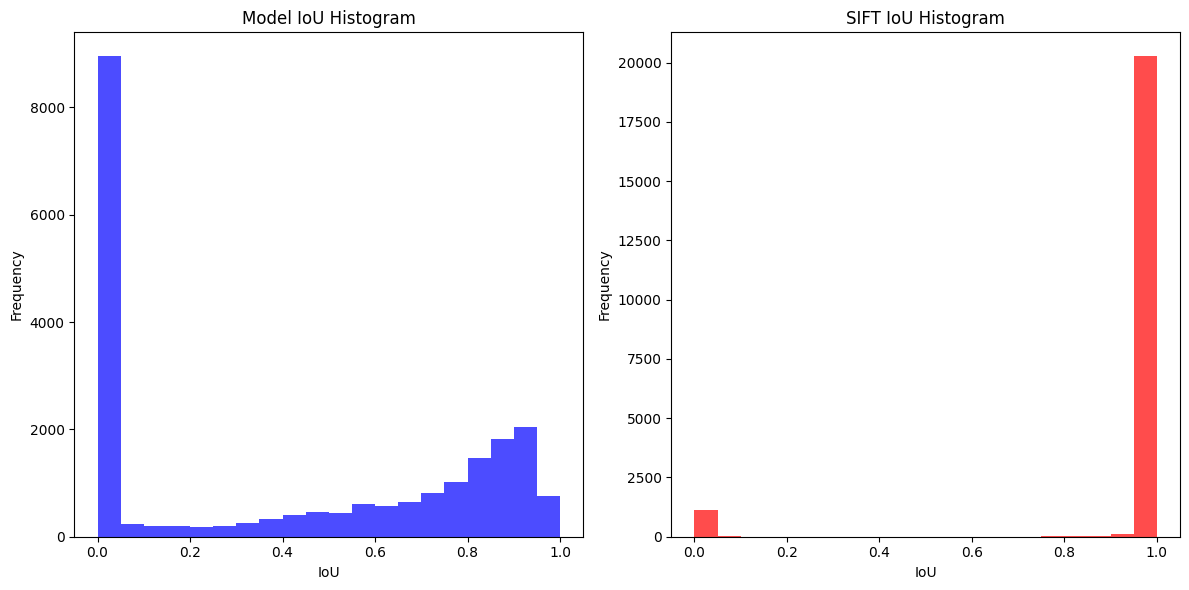

In [4]:
df.model_iou = df.model_iou.astype(float)
df.sift_iou = df.sift_iou.astype(float)
df.sift_time = df.sift_time.astype(float)
df.model_time = df.model_time.astype(float)

ndf = df.copy()
# ndf = ndf[ndf.sift_iou > 0.5]
# Plot the IoU values for the model and SIFT in subplots

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
ndf.model_iou.plot.hist(ax=axes[0], bins=20, color="blue", alpha=0.7)
axes[0].set_title("Model IoU Histogram")
axes[0].set_xlabel("IoU")
axes[0].set_ylabel("Frequency")

ndf.sift_iou.plot.hist(ax=axes[1], bins=20, color="red", alpha=0.7)
axes[1].set_title("SIFT IoU Histogram")
axes[1].set_xlabel("IoU")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

In [12]:
df[["model_iou", "sift_iou", "model_time", "sift_time"]].describe()

model_iou      sift_iou    model_time     sift_time
count  21627.000000  21627.000000  21627.000000  21627.000000
mean       0.415356      0.945153      0.020917      0.088319
std        0.391032      0.223428      0.112210      0.030342
min        0.000000      0.000000      0.000499      0.010363
25%        0.000000      1.000000      0.000537      0.069422
50%        0.432000      1.000000      0.000572      0.083969
75%        0.825000      1.000000      0.000607      0.101738
max        1.000000      1.000000      1.225988      0.898370

In [11]:
df.columns

Index(['image_name', 'label', 'bbox', 'model_iou', 'ann_id', 'model_time',
       'model_gpu_memory', 'model_memory', 'sift_iou', 'sift_time'],
      dtype='object')

## Plot Sample Images

Number of images where model_iou > sift_iou: 40
Number of images where both model_iou and sift_iou == 0: 816
Number of images where sift_iou > model_iou: 20575
Processing: Top 5 images where model_iou > sift_iou
Saved: output\model_better\000000325347_result_1.png
Saved: output\model_better\000000248111_result_2.png
Saved: output\model_better\000000159791_result_3.png
Saved: output\model_better\000000462629_result_4.png
Saved: output\model_better\000000157365_result_5.png
Processing: Top 5 images where both model_iou and sift_iou == 0
Saved: output\both_zero\000000518770_result_1.png
Saved: output\both_zero\000000313454_result_2.png
Saved: output\both_zero\000000100723_result_3.png
Saved: output\both_zero\000000160556_result_4.png
Saved: output\both_zero\000000275749_result_5.png
Processing: Top 5 images where sift_iou > model_iou
Saved: output\sift_better\000000293200_result_1.png
Saved: output\sift_better\000000253452_result_2.png
Saved: output\sift_better\000000547144_result_3.png
S

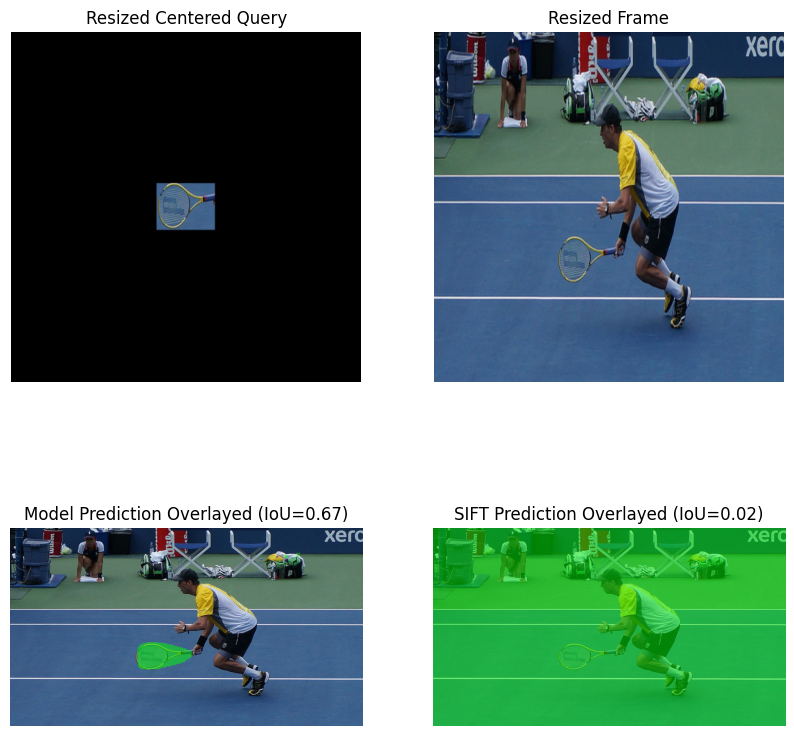

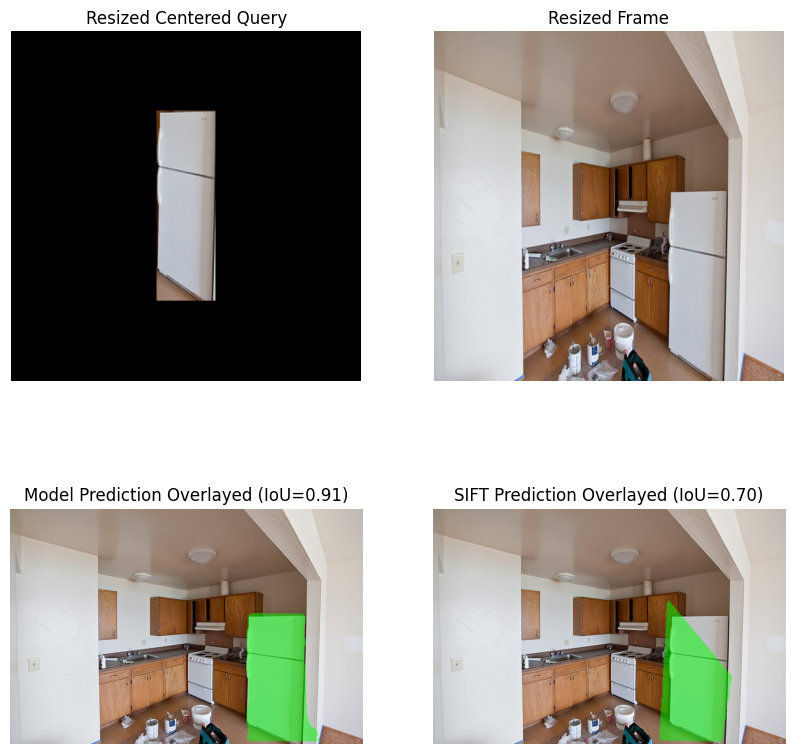

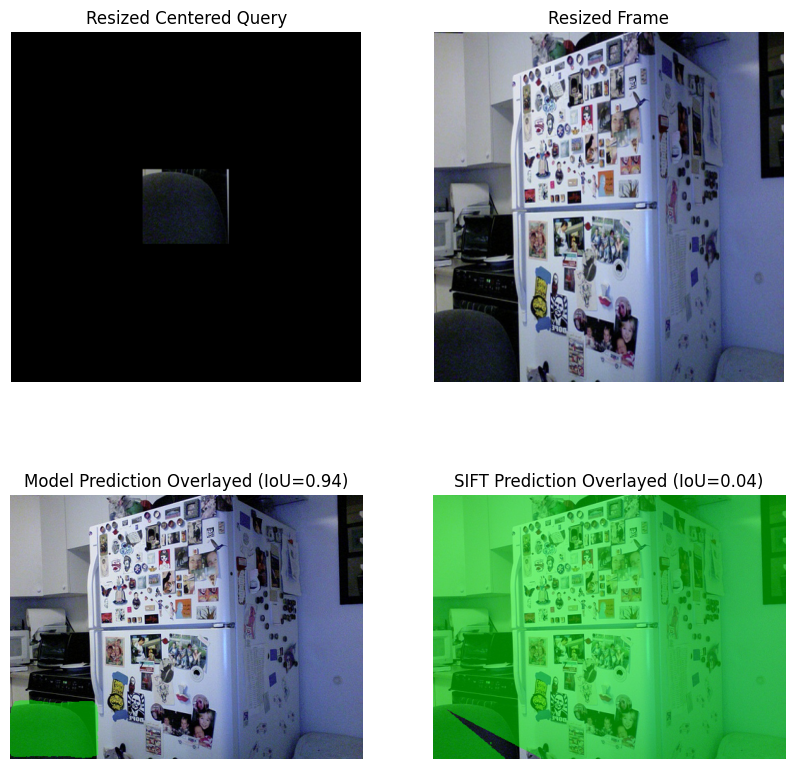

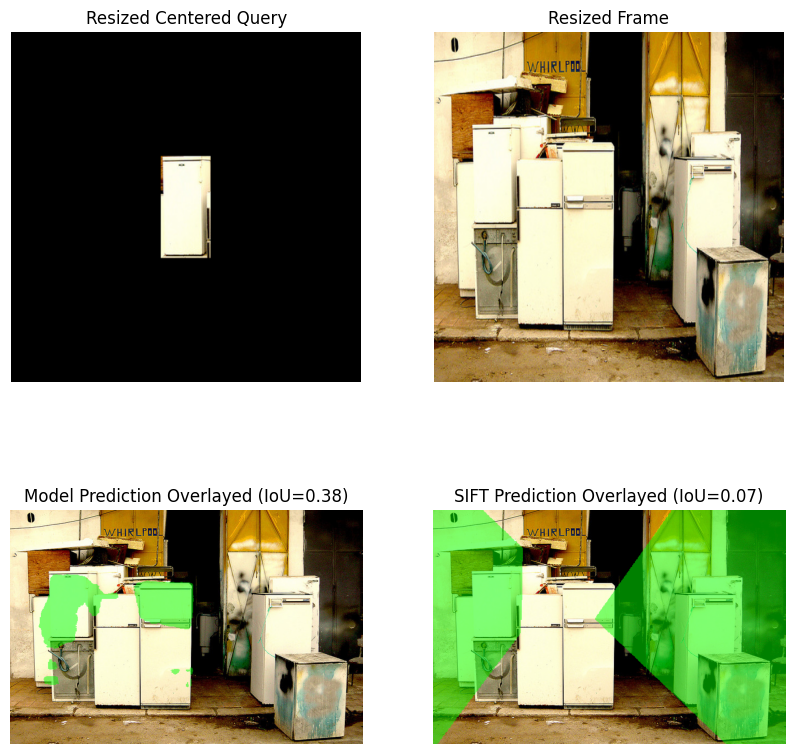

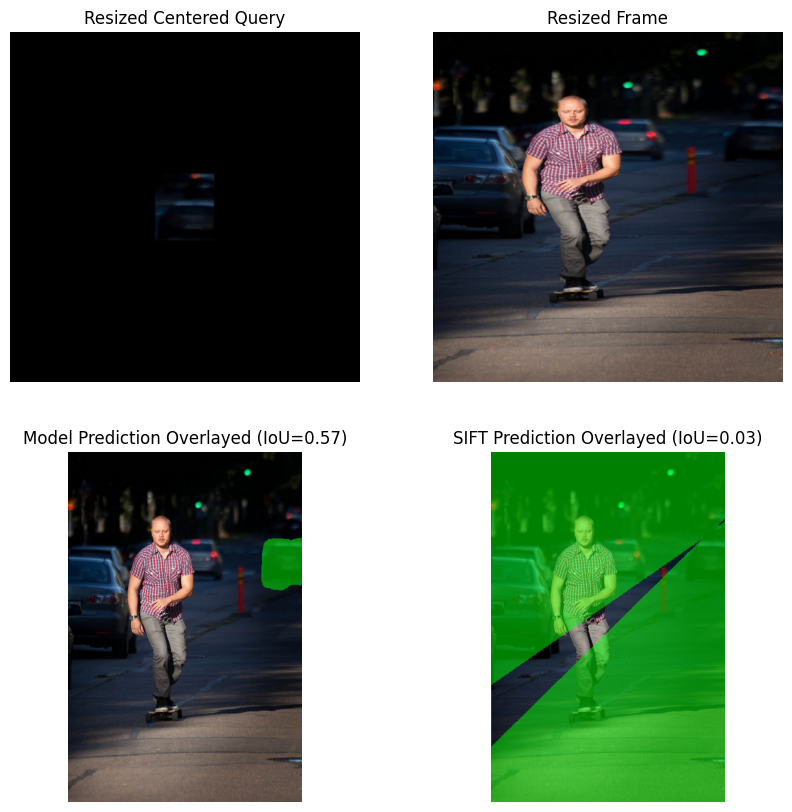

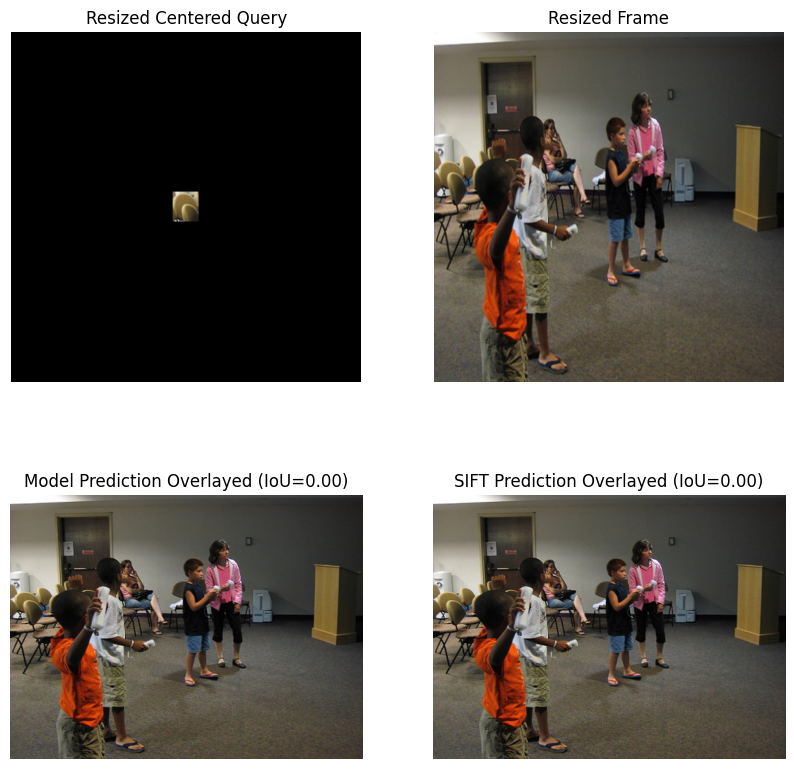

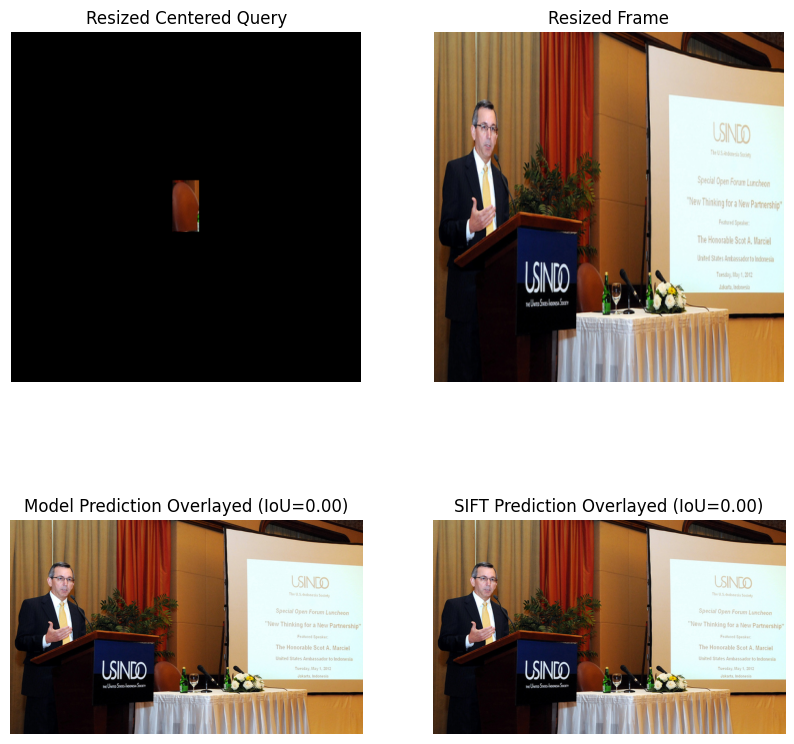

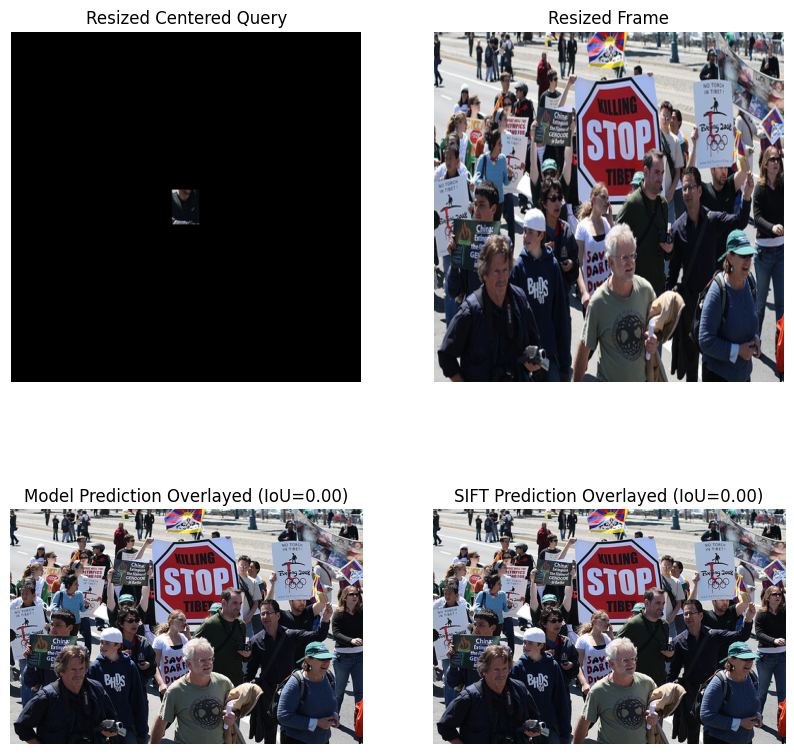

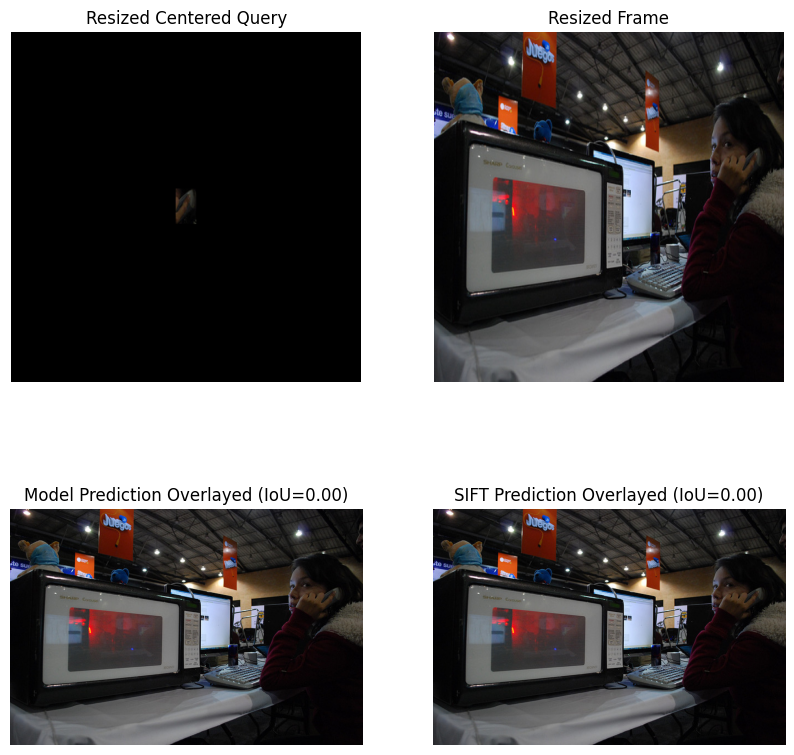

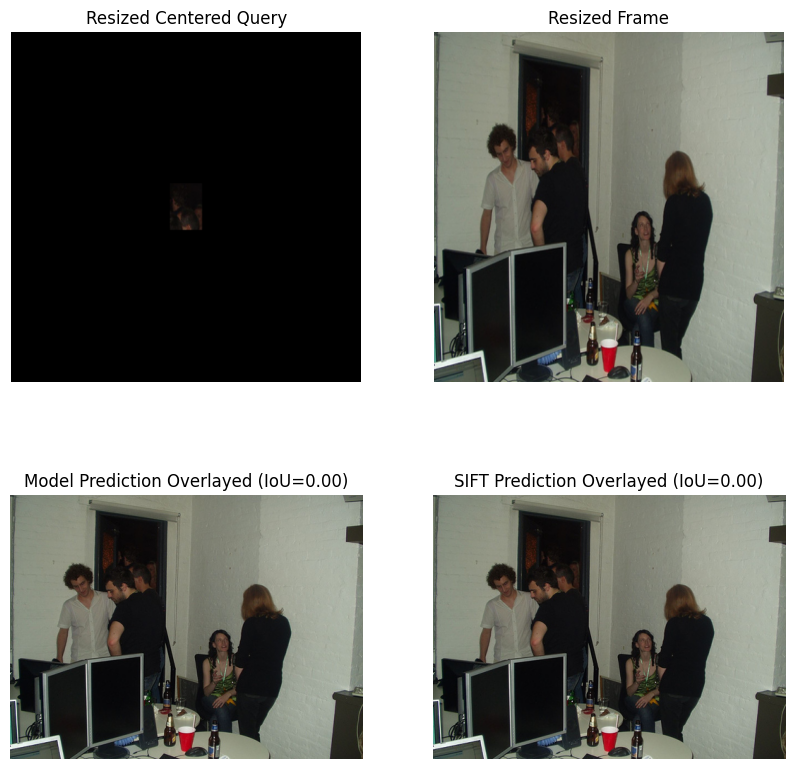

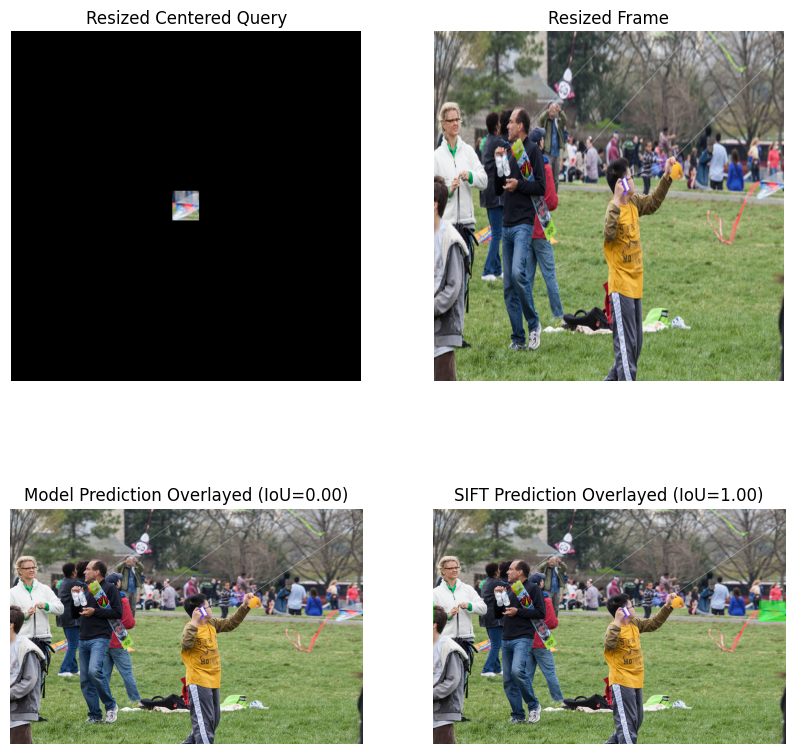

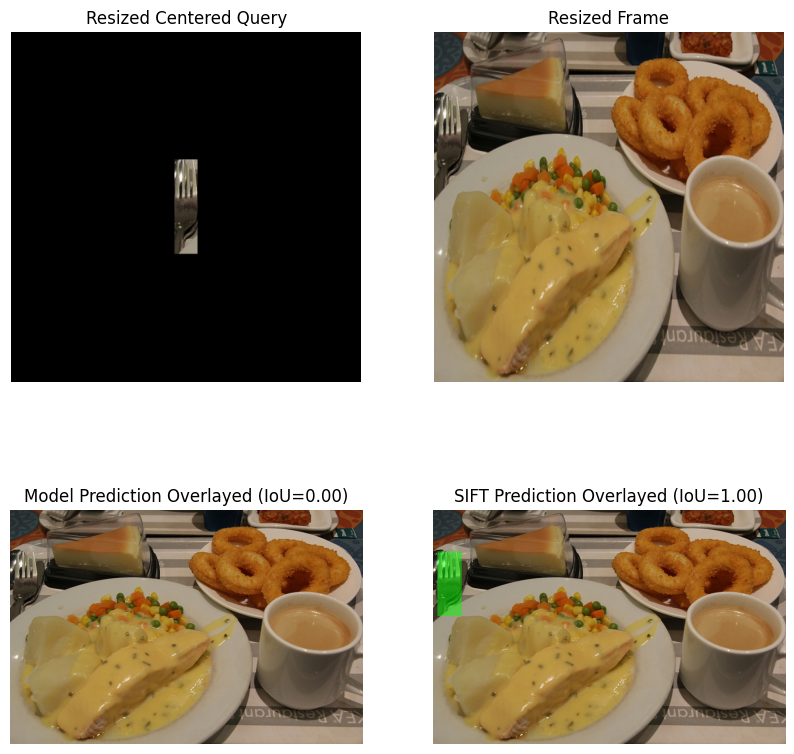

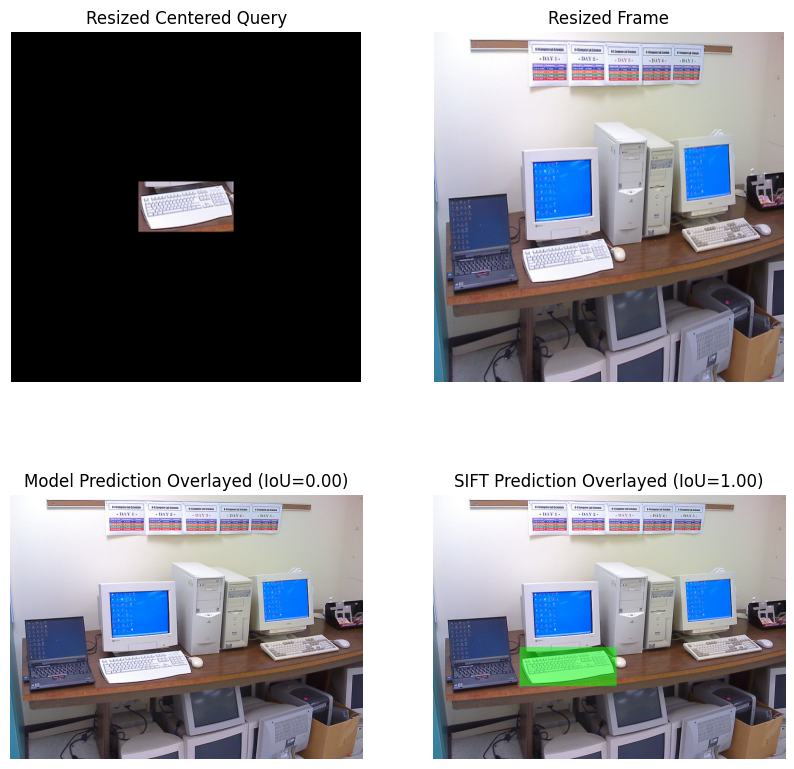

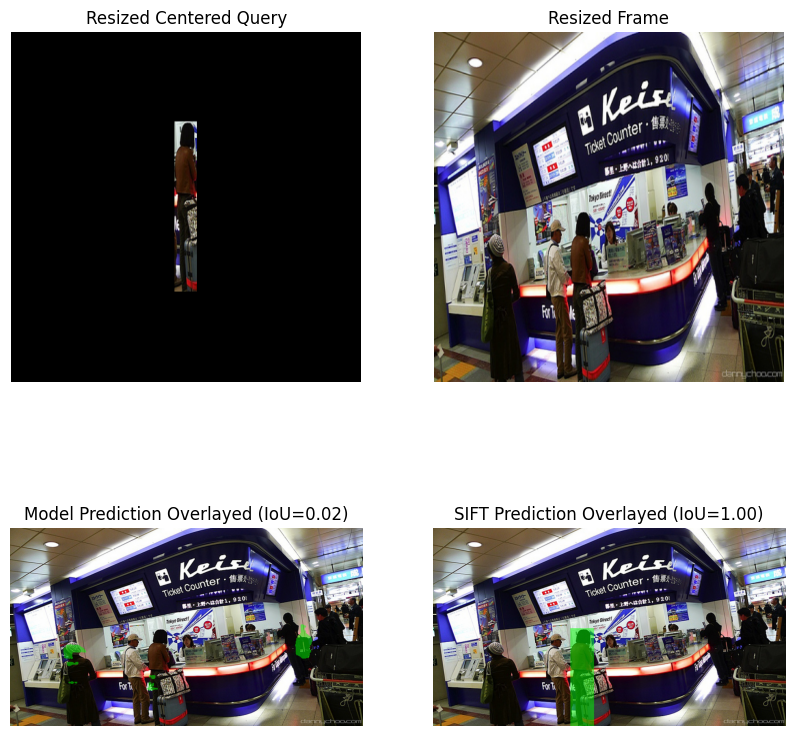

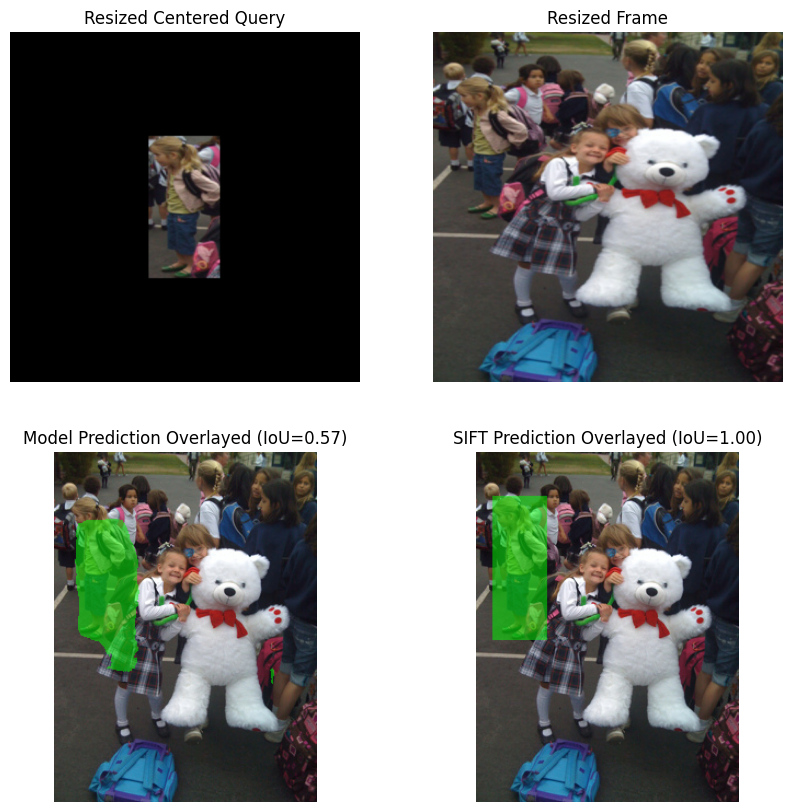

In [20]:
# Define the maximum number of iterations
max_iter = 5

# Filter the DataFrame for the required conditions
ndf_model_better = df.query("model_iou >  sift_iou and sift_iou>0.01").copy()
ndf_model_better = ndf_model_better.sample(frac=1).reset_index(drop=True)  # Shuffle
print(f"Number of images where model_iou > sift_iou: {len(ndf_model_better)}")

# 2. Where both model_iou and sift_iou == 0
ndf_both_zero = df.query("model_iou == 0 and sift_iou == 0").copy()
ndf_both_zero = ndf_both_zero.sample(frac=1).reset_index(drop=True)  # Shuffle
print(f"Number of images where both model_iou and sift_iou == 0: {len(ndf_both_zero)}")

# 3. Where sift_iou > model_iou
ndf_sift_better = df.query("sift_iou > model_iou").copy()
ndf_sift_better = ndf_sift_better.sample(frac=1).reset_index(drop=True)  # Shuffle
print(f"Number of images where sift_iou > model_iou: {len(ndf_sift_better)}")


# Function to process, visualize, and save the images
def process_and_save(ndf, folder_name, max_iter=5):
    # Create the folder if it doesn't exist
    output_dir = Path(folder_name)
    output_dir.mkdir(parents=True, exist_ok=True)

    itr = 0
    for idx, row in ndf.iterrows():
        img_name = row["image_name"]
        bbox = row["bbox"]
        img = cv2.imread(img_name)

        # Convert to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Extract bounding box
        x, y, w, h = map(int, bbox[1:-1].split(","))

        # Generate query
        query = img[y : y + h, x : x + w]
        centered_query = set_query(query, img)

        # Decode the RLE mask for model
        mask_path = Path(img_name).stem + f"_{row['ann_id']}_" + "model_rle.txt"
        mask_path = csv_path.parent / mask_path
        output = rle_decode(mask_path)

        # Decode the RLE mask for SIFT
        sift_mask_path = Path(img_name).stem + f"_{row['ann_id']}_" + "sift_rle.txt"
        sift_mask_path = csv_path.parent / sift_mask_path
        sift_output = rle_decode(sift_mask_path)

        # Overlay the masks
        overlayed_model = overlay_mask(img, output)
        overlayed_sift = overlay_mask(img, sift_output)

        # Visualize the results (without the true mask)
        fig = subplot_images(
            [
                centered_query,
                cv2.resize(img, (512, 512)),
                overlayed_model,
                overlayed_sift,
            ],
            order=(2, 2),
            titles=[
                "Resized Centered Query",
                "Resized Frame",
                f"Model Prediction Overlayed (IoU={row['model_iou']:.2f})",
                f"SIFT Prediction Overlayed (IoU={row['sift_iou']:.2f})",
            ],
            show=False,
        )

        # Save the figure to the folder
        output_file = output_dir / f"{Path(img_name).stem}_result_{itr + 1}.png"
        fig.savefig(output_file)
        print(f"Saved: {output_file}")

        itr += 1
        if itr == max_iter:
            break


# Process and save for each condition
print("Processing: Top 5 images where model_iou > sift_iou")
process_and_save(ndf_model_better, "output/model_better")

print("Processing: Top 5 images where both model_iou and sift_iou == 0")
process_and_save(ndf_both_zero, "output/both_zero")

print("Processing: Top 5 images where sift_iou > model_iou")
process_and_save(ndf_sift_better, "output/sift_better")

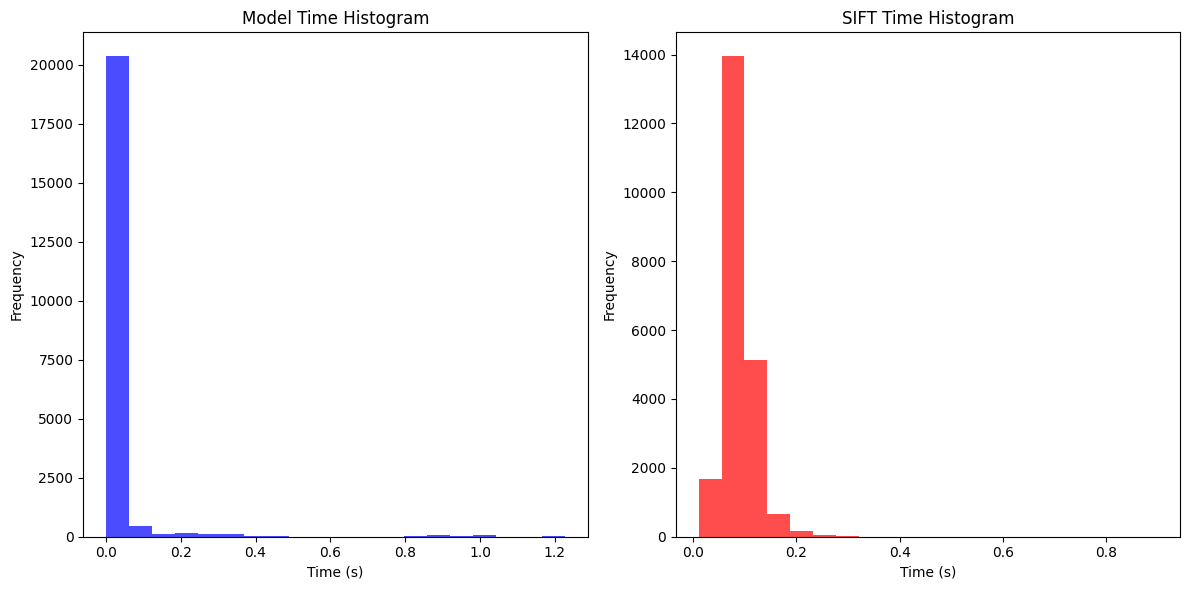

In [8]:
# Plot the time taken by the model and SIFT in subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
ndf.model_time.plot.hist(ax=axes[0], bins=20, color="blue", alpha=0.7)
axes[0].set_title("Model Time Histogram")
axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("Frequency")

ndf.sift_time.plot.hist(ax=axes[1], bins=20, color="red", alpha=0.7)
axes[1].set_title("SIFT Time Histogram")
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()